# Plug flow reactor simulation of Thruster

![caption](Graphics/thruster-details.png)


In [2]:
import cantera as ct
import numpy as np

from matplotlib import pyplot as plt
import csv
import os
import re
import itertools
import pandas as pd
from collections import defaultdict

In [3]:
# default if not using SLURM array
cat_area_per_vol = 3e6 # m2/m3
temperature_c = 400 # ºC
rtol = 1e-11
atol = 1e-24
residual_threshold = 5e-3

# input file containing the reaction mechanism
cti_file = '../RMG-model/cantera/chem_annotated.cti'
#cti_file = '../RMG-model/cantera/chem0050.cti'

In [4]:
#cantera
gas=ct.Solution(cti_file)
surf = ct.Interface(cti_file,'surface1', [gas])

In [5]:
print(f"Catalyst area per volume {cat_area_per_vol :.2e} m2/m3")
print(f"Initial temperature      {temperature_c :.1f} ºC")
print(f"Solver RTOL              {rtol :.1e}")
print(f"Solvel ATOL              {atol :.1e}")

Catalyst area per volume 3.00e+06 m2/m3
Initial temperature      400.0 ºC
Solver RTOL              1.0e-11
Solvel ATOL              1.0e-24


In [6]:
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         0.81974  kg/m^3
  mean mol. weight         20.1797  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          1905.6        3.845e+04     J
   internal energy      -1.217e+05       -2.456e+06     J
           entropy          7257.7        1.465e+05     J/K
    Gibbs function     -2.1754e+06        -4.39e+07     J
 heat capacity c_p          1030.1        2.079e+04     J/K
 heat capacity c_v          618.03        1.247e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                Ne              1                1         -17.5994
     [ +186 minor]              0                0



In [7]:
print(", ".join(gas.species_names))

Ne, NH3(2), NH2OH(3), HNO3(4), CH3OH(5), H2O(6), N2(7), O2(8), NO2(9), NO(10), N2O(11), CO2(12), H2(13), CO(14), CH4(15), C2H6(16), CH2O(17), CH3(18), C3H8(19), H(20), C2H5(21), HCO(22), CH3CHO(23), OH(24), C2H4(25), O(36), Ar(37), HO2(39), H2O2(40), HOCO(41), CH2(42), CH2(S)(43), CH(44), CH2OH(45), CH3O(46), HCOH(47), CH3OO(48), CH2CO(49), C2H3(50), C(51), C2H2(52), C2H(53), CH3OOH(54), CH2OOH(55), HOCH2O(56), HOCHO(57), C2H5O(58), C2H5O2(59), C2H5O2(60), cC2H4O(61), CH2CHO(62), H2CC(63), CH3CO(64), C2H4O(65), C2H5O(66), C2H3O2(67), CHCHO(68), OCHCHO(69), HCCO(70), HCCOH(71), CHCHOH(72), C2(73), C2O(74), C2H6O(75), C2H5O(76), C2H5O3(77), cC2H3O(78), C2H3O3(79), OCHCO(80), C2H6O2(81), C2H5O2(82), C2H4O2(83), OCHO(84), NH2(85), NH(86), HNO(87), H2NO(88), HON(89), N(90), NNH(91), HONO(92), HNOH(93), HNO2(94), NO3(95), N2H2(96), H2N2(97), N2H3(98), N2H4(99), HCN(100), CN(101), HNC(102), NCO(103), HOCN(104), HNCO(105), NCCN(106), HNCN(107), NCN(108), HNCNH(109), HCNO(110), CH3CN(111), CH2C

In [8]:
print(", ".join(surf.species_names))

X(1), HX(26), OX(27), CH3X(28), HOX(29), H2OX(30), CO2X(31), OCX(32), CX(33), CH2X(34), CHX(35), H2NX(201), H3NX(202), H2NOX(203), H2NOX(204), H3NOX(205), NO2X(206), NO3X(207), HNO3X(208), CH3OX(209), CH3OX(210), CH4OX(211), OX(213), NOX(215), NO2X(216), NOJX(217), H2X(219), SX(494), SX(495), CHO2X(506), HNO2X(513), HNX(532), HNOX(533), NX(604), SX(605), SX(606), SX(609), H2N2X(614), N2O3X(618), SX(623), HNOX(631), H2NOX(633), HNO2X(741), SX(759), HONOX(934), SX(1000), SX(1039), SX(1043), SX(1047), SX(1048), SX(1050), SX(1063), SX(1064), HNOX(1071), SX(1163), SX(1249), N2OX(1419), CNOX(1438), SX(1527), SX(1895), SX(2232), SX(2233), SX(2465), SX(3049), SX(3050), SX(3248), SX(3939), SX(4539), SX(4540), NO3X(4718), SX(4793), SX(4794), SX(4937), SX(5513), SX(5810), SX(5814), SX(6977), SX(7604), SX(9643)




This example solves a plug flow reactor problem, with coupled surface and gas chemistry.





In [9]:
# unit conversion factors to SI
cm = 0.01 # m
minute = 60.0  # s

In [10]:
#######################################################################
# Input Parameters for combustor
#######################################################################
mass_flow_rate =  0.5e-3 # kg/s
#temperature_c = 550.0  # Initial Temperature in Celsius
print(f"Initial temperature {temperature_c :.1f} ºC")
pressure = ct.one_atm # constant

diameter = 1.8*cm #18mm diameter circle.
length = 1.1 * cm  # Catalyst bed length. 11mm
cross_section_area = np.pi * (0.9*cm)**2  # Catalyst bed area.  18mm diameter circle.

### Catalyst properties. Some are hard to estimate
# if we can, update this lit value or verify the value richard calculated
porosity = 0.38  # Catalyst bed porosity (0.38)
# Al2O3 particles are about 0.7mm diameter
cat_specific_area = 140 # m2/g
print(f"Catalyst specific area {cat_specific_area :.2e} m2/g")
cat_density = 4 / cm**3 # 4 g/cm3
print(f"Catalyst density {cat_density :.2e} g/m3")
cat_area_per_reactor_vol = cat_specific_area * cat_density # m2/m3
print(f"Catalyst area per total reactor volume {cat_area_per_reactor_vol :.2e} m2/m3")
cat_area_per_gas_vol = cat_area_per_reactor_vol / porosity # porosity is gas vol per reactor vol
print(f"Catalyst area per gas volume {cat_area_per_gas_vol :.2e} m/m3")

#cat_area_per_vol =  cat_area_per_gas_vol * 1e-3 # REDUCE BY A LOT

cat_area_per_vol = 2.80e+05 #Mary Lou changed this because it made sim. work

print(f"\nCatalyst area per volume in use for this simulation: {cat_area_per_vol :.2e} m2/m3")


Initial temperature 400.0 ºC
Catalyst specific area 1.40e+02 m2/g
Catalyst density 4.00e+06 g/m3
Catalyst area per total reactor volume 5.60e+08 m2/m3
Catalyst area per gas volume 1.47e+09 m/m3

Catalyst area per volume in use for this simulation: 2.80e+05 m2/m3


## For temp profile

In [11]:
from scipy.integrate import solve_ivp
#Values needed for T profiles, from Mitsubishi 'Issues by Dr Tsutiyama' pdf
cat_thermal_conductivity = 0.34/cm #W/cm-K --> W/m-K
a_prime = (1-porosity)/porosity
a = cat_area_per_vol #assume for now. ask though [1/m]
gas.thermal_conductivity #[W/m/K]
gas.cp #[J/kg/K]
gas.viscosity #Pa-s
gas.density #kg/m^3 (confirmed- this is mass basis)
gas_Pr = gas.cp*gas.viscosity/gas.thermal_conductivity

init_velocity = mass_flow_rate / (gas.density * cross_section_area) #m/s
#[kg/s]/([kg/m^3]*[m^2]) 
# sphere_diam = 0.3e-3 #m, D=0.3mm (where did I get that #? should be .7) 
sphere_diam = 0.7e-3 #m, D=0.7mm
kinematic_viscosity = gas.viscosity/gas.density

#emissivity of catalyst & propellant? 
eps_p = 0.9
eps_f = 0.5
stefboltz = 5.670e-8 #W/m^2-K^4W/m^2-K
a_double_prime = 4/diameter #outer surface area/ volume
eps_prime = 1/eps_p + 1/eps_f -1 

Re_D = init_velocity*sphere_diam/kinematic_viscosity
print('Reynolds #: {:.1f} (supposed to be above 90 for this correlation)'.format(Re_D)) #a little low to start
h = gas.density * init_velocity*gas.cp/porosity*(2.06*Re_D**(-0.575))*gas_Pr**(-2/3) #

print('average h: {:.0f} W/m-K'.format(h)) 

Reynolds #: 109.6 (supposed to be above 90 for this correlation)
average h: 965 W/m-K


In [12]:
eps_prime

2.111111111111111

For a packed bed of spheres with porosity $\phi$, specific surface area (per unit bulk vol) is given by:

\begin{equation}
a = \frac{4 \pi (D_p/2)^2}{4/3 \pi (D_p/2)^3}(1-\phi) = \frac{6}{D_p}(1-\phi)
\end{equation}

source: http://www.owlnet.rice.edu/~ceng402/Hirasaki/CHAP3D.pdf

This a turns out to be much smaller than 'cat_area_per_vol' 

In [13]:
a = 6/sphere_diam*(1-porosity) #m^2/m^3

print(f"this value is {cat_area_per_vol/a:.2f}x smaller than 'cat_area_per_unit_vol'")

this value is 52.69x smaller than 'cat_area_per_unit_vol'


# From MHI:
from Mitsubishi 'Issues by Dr Tsutiyama' pdf equations in the Dropbox.

##### Surface Heat:
Heat generation at catalyst = reaction heat at surface - heat transfer to fluid - heat transfer from wall:
\begin{equation}
\lambda a'\frac{\partial^2T_p}{\partial z^2} = r \Delta H (1-\alpha)-h_ga(T_p - T_f)-\sigma a( \epsilon_p T_p^4 - \epsilon_f T_f^4) - a'' \sigma \epsilon_p T_p^4
\end{equation}

 - The $a'$ parameter is $\frac{1-\varepsilon}{\varepsilon}$, and since $\varepsilon = \frac{\text{gas volume}}{\text{reactor volume}}$, $\frac{1-\varepsilon}{\varepsilon} =a' = \frac{\text{cat. volume}}{\text{gas volume}}$. 
 - The right hand side (RHS) of this temperature profile equation has units of $\text{W}/\text{m}^3$
 - $r \Delta H (1-\alpha) =$ surf.net_rates_of_progress $\cdot$ surf.delta_enthalpy
 - r [kmol/m$^3$s]

##### Gas Heat:
Fluid temp increase = reaction heat in fluid + heat transfer from catalyst:

\begin{equation}
\rho_f C_f u \frac{\partial T_f}{\partial z} = r \Delta H \alpha + a[h_g(T_p - T_f) + \sigma(\epsilon_p'T_p^4 - \epsilon_f'T_f^4)]
\end{equation}
 - $r \Delta H \alpha =$ gas.net_rates_of_progress $\cdot$ gas.delta_enthalpy


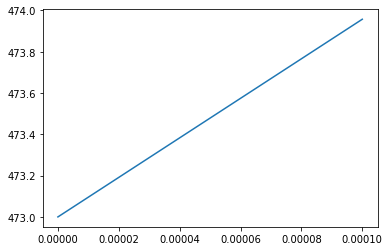

In [14]:
def surf_dT(z,T_info):
    '''
    takes T_info = [surf.T, dT/dz]_inlet and returns [dT/dZ, d^2T/dz^2]_outlet
    units: dT/dz [K/m], d^2T/dz^2 [K/m^2]
    
    working from Mitsubishi 'Issues by Dr Tsutiyama' pdf equations 
    and 8-PDEs shooting method example for 2nd deriv. 
    (using deltaT/deltaZ as 'guess' for 1st deriv initial value)
    assuming 1D (bad assumption-- D>L)
    '''
#     cat_thermal_conductivity = 0.34#W/cm-K
    
    temp, dT1dz = T_info
    
    surf.TP = temp, pressure
    
    surface_heat = cat_area_per_vol*np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    #[m^2/m^3]*[kmol/m^2/s]*[J/kmol] = W/m^3
    convection_term = cat_area_per_vol*h*(surf.T - gas.T) # W/m^3
    #[m^2/m^3]*[W/m^2/K]*[K] = W/m^3
    radiation_fluid = stefboltz*cat_area_per_vol*(eps_p*(surf.T)**4-eps_f*(gas.T)**4)
    #[W/m^2-K^4]*[m^2/m^3]*[K^4] = W/m^3
    radiation_wall = a_double_prime*stefboltz*eps_p*(surf.T)**4
    #[m^2/m^3]*[W/m^2-K^4]*[K^4] = W/m^3
    
    dT2dz = (surface_heat - convection_term - radiation_fluid - radiation_wall)/(cat_thermal_conductivity*100*a_prime) #K/m^2
#     print(gas.delta_enthalpy)
#     print(surf.delta_enthalpy)
#     print(surface_heat)
#     print(convection_term)
#     print(dT2dz)

    return dT1dz, dT2dz #K/m, K/m^2
surf.TP = 473, pressure
dz = .01*cm
ans = solve_ivp(surf_dT,[0,dz],[473,1/dz])
plt.plot(ans.t,ans.y[0])
# surf.TP = ans.y[0,-1], pressure

# surf_dT(1,[473,1e-4])

array([0.00000000e+00, 7.25081892e-06, 1.00000000e-05])

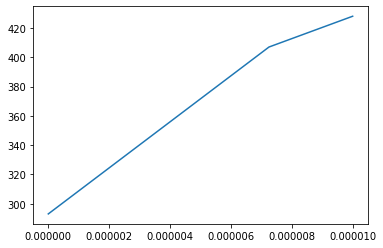

In [15]:
def gas_dT(z,T):
    '''
    takes T_inlet of gas and returns dTdz of gas phase based on Mitsubishi paper, 1D
    use solve_ivp
    '''
    gas.TP = T, pressure
    gas_heat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    #[kmol/m^3/s]*[J/kmol] = W/m^3
    convection_term = cat_area_per_vol*h*(surf.T - gas.T) # W/m^3
    #[m^2/m^2]*[W/m^2-K]*[K] = W/m^3
    radiation = cat_area_per_vol*stefboltz*(eps_prime*(surf.T)**4-eps_prime*(gas.T)**4)
    
    velocity = mass_flow_rate / (gas.density * cross_section_area)
    
    dTgdz = (gas_heat + convection_term + radiation)/(gas.density*gas.cp*velocity)
    return dTgdz

surf.TP = 473, pressure
test = solve_ivp(gas_dT, [0,1e-5], [293])
plt.plot(test.t,test.y[0])
test.t

In [16]:
solve_ivp?

In [17]:
# plt.plot(test.t, test.y[0],label = 'gas')
# plt.plot(test.t, test.y[1],label='surf')
# plt.legend()

In [18]:
def temp_profile(z,Temps_and_derivs):
    
    Tf,Tp, dTpdz = Temps_and_derivs
#     dTfdz = gas_dT(z,Tf)
#     dTpdz, dTp2dz2 = surf_dT(z,[Tp,dTpdz])

    assert Tp > 0
    
    gas.TP = Tf, pressure
    surf.TP = Tp, pressure
    
    gas_heat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    #[kmol/m^3/s]*[J/kmol] = W/m^3
    surface_heat = cat_area_per_vol*np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    #[m^2/m^3]*[kmol/m^2/s]*[J/kmol] = W/m^3
    convection_term = cat_area_per_vol*h*(surf.T - gas.T) # W/m^3
    #[m^2/m^2]*[W/m^2-K]*[K] = W/m^3
    
    
    radiation = cat_area_per_vol*stefboltz*(eps_prime*(surf.T)**4-eps_prime*(gas.T)**4)
    velocity = mass_flow_rate / (gas.density * cross_section_area)
    
    dTfdz = (gas_heat + convection_term + radiation)/(gas.density*gas.cp*velocity)
    

    radiation_fluid = stefboltz*cat_area_per_vol*(eps_p*(surf.T)**4-eps_f*(gas.T)**4)
    #[W/m^2-K^4]*[m^2/m^3]*[K^4] = W/m^3
    radiation_wall = a_double_prime*stefboltz*eps_p*(surf.T)**4
    #[m^2/m^3]*[W/m^2-K^4]*[K^4] = W/m^3
    
    dTp2dz2 = (surface_heat - convection_term - radiation_fluid - radiation_wall)/(cat_thermal_conductivity*100*a_prime) #K/m^2

    
    return dTfdz, dTpdz, dTp2dz2

# test = solve_ivp(temp_profile, [0,r_len],[400,473,1])
# # surf.T
# plt.plot(test.t, test.y[0],label = 'gas')
# plt.plot(test.t, test.y[1],label='surf')
# plt.legend()
# # test

In [19]:
gas.T,surf.T, gas.density
gas_heat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) 
gas_heat

# gas.density*gas.cp
gas.basis

'mass'

In [20]:
output_filename = 'surf_pfr_output_mlou_test.csv'

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 22001

#####################################################################
temperature_c = 20
temperature_kelvin = temperature_c + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')

# From HAN-molefractions.ipynb
feed_mole_fractions = {
    'NH3(2)': 0.031,
    'NH2OH(3)': 0.32,
    'HNO3(4)': 0.35,
    'CH3OH(5)': 0.21,
    'H2O(6)': 0.09,
}
gas.TPX = temperature_kelvin, pressure, feed_mole_fractions


# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = 473, pressure
surf.coverages = 'X(1):1.0'

r_len = length/(NReactors-1) 
r_vol = cross_section_area * r_len * porosity # gas volume

# catalyst area in one reactor
cat_area = cat_area_per_vol * r_vol

# Not sure we need the velocity
velocity = mass_flow_rate / (gas.density * cross_section_area)

In [21]:
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.reverse_rates_of_progress[i]:8.1g}")

    print(f"\nSurface rates have been scaled by surface/volume ratio {cat_area_per_vol:.1e} m2/m3")
    print("So are on a similar basis of volume of gas")
    print(" kmol / m3 / s")
# report_rates()

In [22]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
297 : CH2OH(45) + NO(10) <=> S(1494)                     9.7e+24
242 : CH2OH(45) + NO2(9) <=> S(1216)                     9.7e+24
438 : CH2OH(45) + HNOH(93) <=> ONCO(1021)                9.7e+24
475 : HCO(22) + HNOH(93) <=> ONCDO(266)                  9.7e+24
480 : HCO(22) + HNO(630) <=> S(665)                      9.7e+24
296 : CH2OH(45) + H2NO(88) <=> S(1108)                   9.7e+24
597 : HCO(22) + NO2(9) <=> CHNO3(372)                    9.7e+24

Highest forward rate constants, surface
 84 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 95 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
468 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
746 : SX(1043) + X(1) <=> HX(26) + SX(1050)              3.7e+20
142 : SX(1039) + X(1) <=> HX(26) + SX(1047)              3.7e+20
 16 : HX(26) + OX(27) <=> HOX(29) + X(1)                 7.4e+18
490 : 2 CH2X(34) <=> CH3X(28) + CHX(35)                  4.1e+18

Highest rev

In [23]:
def fix_rates(phase, limit):
    """
    Fix reverse reaction rates that are too fast.
    """
    for i in np.argsort(abs(phase.reverse_rate_constants))[-1:0:-1]:
        if phase.reverse_rate_constants[i] < limit:
            break
#         print(f"Before: {i:3d} : {phase.reaction_equation(i):48s}  {phase.reverse_rate_constants[i]:8.1e}")
        multiplier = limit / phase.reverse_rate_constants[i]
        phase.set_multiplier(multiplier, i)
#         print(f"After:  {i:3d} : {phase.reaction_equation(i):48s}  {phase.reverse_rate_constants[i]:8.1e}")
        
#fix_rates(gas, 1e18)
#fix_rates(surf, 1e21)

In [25]:
gas.TPX = temperature_kelvin, pressure, feed_mole_fractions
surf.coverages = 'X(1):1.0'
# #surf.coverages = starting_coverages
# surf.TP = 473, pressure
# TDY = gas.TDY

# r.T,surf.T,gas.T
# # TDY
# solve_ivp?


In [ ]:
# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

temperature_kelvin = 20 + 273

gas.TPX = temperature_kelvin, pressure, feed_mole_fractions
surf.coverages = 'X(1):1.0'

TDY = gas.TDY
cov = surf.coverages

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='off')
surf.TP = 150 +273, pressure
# print(surf.T)
r.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)


#try resovoirs for surf phase?
upstream_surf = ct.Reservoir(surf, name='upstream_surf')
downstream_surf = ct.Reservoir(surf, name='downstream_surf')

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 24

# set relative and absolute tolerances on the simulation
sim.rtol = 1e-11
sim.atol = 1e-21

sim.verbose = False

# surf.set_multiplier(0.)  # turn off surface reactions
# surf.set_multiplier(1e6)  # make surface reactions a million times faster

r.volume = r_vol
rsurf.area = cat_area

integration_flux_data = defaultdict(float)

outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['Distance (mm)', 'gas T (C)', 'surf T (C)', 'P (atm)'] +
                gas.species_names + surf.species_names + ['gas_heat','surface_heat','alpha'])

print('   distance(mm)  surf.T (C)    gas.T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha')

violating_rxns = []
violating_sticks = []
violating_indeces = []

dz = r_len

for n in range(NReactors):
    """
    if n == 0: # first coulpe of reactors are tiny
        surf.set_multiplier(0.)
        r.volume = r_vol * 1e-2
        rsurf.area = cat_area * 1e-2
    if n == 3:
        r.volume = r_vol
        rsurf.area = cat_area"""
        
#     if n == 0: # start off with inert packing, no surface reactions
#         surf.set_multiplier(0.)
# #         surf.TP = 473, pressure
#     if n == int(0.001 * NReactors / length): # after 1 mm, catalyst
#         surf.set_multiplier(1.)
    
#     fix_rates(surf, 1e22)
#         save_flux_diagrams(gas, surf, suffix='1mm')
#         show_flux_diagrams(gas, surf, suffix='1mm', embed=True)
    
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = TDY = r.thermo.TDY
    
    cov = surf.coverages
    upstream.syncState()
    upstream_surf.syncState()

    z = n * r_len
    Tp_o = surf.T
#     T1f = gas.T
    sim.reinitialize()

    try:
#       the default is residual_threshold = sim.rtol*10
#         sim.advance_to_steady_state(residual_threshold = residual_threshold)
#         dt = 1e-3 #sec
        dt = dz/velocity #s
        sim.advance(dt)#how much?
#         sim.advance_to_steady_state()
        surf.TP = Tp_o, pressure
#         print(f"AFTER sim.advance: surf: {surf.T}, gas: {gas.T}")

    except ct.CanteraError:
        t = sim.time
        sim.set_initial_time(0)
        gas.TDY = TDY
        surf.coverages = cov
        r.syncState()
        sim.reinitialize()
        new_target_time = 0.01 * t
        print(f"Couldn't reach {t:.1g} s so going to try {new_target_time:.1g} s")
        #save_flux_diagrams(gas, surf)
        #show_flux_diagrams(gas, surf, embed=True)
        report_rates()
        report_rate_constants()
        try:
            sim.advance(new_target_time)
        except ct.CanteraError:
            outfile.close()
            raise()
            #report_rate_constants()

    if n == 0:
        dTpdz = 0 #guess
    ans = solve_ivp(temp_profile,[z,z+dz],[gas.T,surf.T,dTpdz],max_step=1e-7)
    plt.plot(ans.t*100,ans.y[0])
    plt.plot(ans.t*100,ans.y[1])
    
    Tf_o = ans.y[0,-1]
    Tp_o = ans.y[1,-1]
    dTpdz = ans.y[2,-1]

    gas.TP = Tf_o, pressure
    surf.TP = Tp_o , pressure
    
    dist = n * r_len * 1.0e3   # distance in mm
        
    gas_heat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    surface_heat = cat_area_per_vol * np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    alpha = surface_heat / (surface_heat + gas_heat) # fraction of heat release that is on surface.

    
    if not n % 10:
        print('    {:10f}  {:7.1f}  {:7.1f}  {:10f}  {:10f}  {:10f} {:10f}  {:5.1e}'.format(dist, surf.T-273.15,gas.T-273.15, *gas['NH3(2)','NH2OH(3)','HNO3(4)','CH3OH(5)'].X, alpha ))
#         print('{:7.1f}  {:7.1f}  {:7.1f}'.format(r.T-273.15,gas.T-273.15,surf.T-273.15))
#         print('\n',cov,'\n')
#       write the gas mole fractions and surface coverages vs. distance
        writer.writerow([dist, gas.T - 273.15, surf.T - 273.15, r.thermo.P/ct.one_atm] +
                    list(gas.X) + list(surf.coverages) + [gas_heat, surface_heat, alpha])
#         print(f"\nheats {gas_heat:.0f}, {surface_heat:.0f}")
        
#     rxns, values, indeces= stick_greater_than_1(surf.T)
    
#     violating_rxns.append(rxns)
#     violating_sticks.append(values)
#     violating_indeces.append(indeces)
    
outfile.close()
print("Results saved to '{0}'".format(output_filename))

# with open("integration_flux_data.txt",'w') as f:
#     for (sp1,sp2),flux in integration_flux_data.items():
#         f.write("{} {} {}\n".format(sp1,sp2,flux))
            

   distance(mm)  surf.T (C)    gas.T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha
      0.000000    106.5     26.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.005000    -53.5     13.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.010000   -145.8     11.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.015000    153.6     27.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.020000     69.2     20.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.025000   -105.7     10.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.030000   -143.6      6.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.035000      0.4     22.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.040000     67.7     18.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.045000   -150.2      5.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.050000   

      0.460000    136.5     24.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.465000   -162.2      7.4    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.470000    -34.8     18.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.475000    152.7     26.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.480000     -5.5     16.4    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.485000   -160.3      6.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.490000   -126.1      8.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.495000   -146.1      6.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.500000    -50.0     13.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.505000   -167.8      6.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.510000   -230.4      4.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.515000   -112

      0.925000    138.2     25.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.930000   -185.7      5.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.935000      8.6     20.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.940000     74.7     21.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.945000   -231.5      5.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.950000    113.1     26.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.955000    -64.6     12.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.960000   -226.7      4.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.965000   -116.7     13.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.970000   -214.7      9.4    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.975000     62.1     26.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      0.980000    -37

      1.390000    -52.7     16.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.395000   -104.7     11.4    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.400000    115.9     26.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.405000   -165.0      9.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.410000    -42.8     15.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.415000     87.2     24.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.420000   -153.2     10.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.425000    -87.6     12.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.430000    135.5     26.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.435000    -51.6     16.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.440000   -205.0      5.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.445000      0

      1.855000     23.8     20.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.860000   -107.9     12.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.865000   -216.1      5.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.870000    -86.6     13.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.875000     44.6     21.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.880000    109.3     25.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.885000    -20.0     17.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.890000   -149.2     10.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.895000   -178.6      7.4    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.900000    -49.8     15.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.905000     79.1     23.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      1.910000     77

      2.320000    119.6     25.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.325000     53.9     22.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.330000    -50.4     15.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.335000   -154.6      9.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.340000   -193.0      6.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.345000    -89.2     12.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.350000     14.7     19.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.355000    118.1     25.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.360000     56.5     22.4    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.365000    -46.4     16.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.370000   -149.2      9.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.375000   -199

      2.785000    -80.0     14.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.790000   -168.8      8.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.795000   -190.6      6.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.800000   -102.1     12.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.805000    -13.6     17.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.810000     74.9     22.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.815000    110.5     25.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.820000     23.0     20.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.825000    -64.8     15.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.830000   -152.5      9.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.835000   -206.9      5.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      2.840000   -120

      3.250000     85.0     24.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.255000      7.0     19.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.260000    -71.0     14.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.265000   -149.0      9.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.270000   -213.5      5.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.275000   -140.3      9.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.280000    -62.6     14.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.285000     15.2     19.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.290000     92.9     24.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.295000     99.9     24.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.300000     22.8     20.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.305000    -54

      3.715000    -43.6     15.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.720000     27.0     20.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.725000     97.6     24.4    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.730000     99.6     24.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.735000     29.5     20.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.740000    -40.7     16.4    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.745000   -110.8     12.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.750000   -180.9      7.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.755000   -191.4      6.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.760000   -121.6     11.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.765000    -51.7     15.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      3.770000     18

      4.180000   -138.3     10.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.185000    -73.6     14.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.190000     -8.9     17.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.195000     55.8     21.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.200000    118.8     25.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.205000     80.4     23.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.210000     16.2     19.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.215000    -48.1     15.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.220000   -112.4     12.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.225000   -176.6      8.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.230000   -199.3      6.4    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.235000   -135

      4.645000     22.1     19.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.650000     82.3     23.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.655000    118.8     26.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.660000     61.1     22.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.665000      1.4     18.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.670000    -58.4     15.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.675000   -118.2     11.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.680000   -177.9      8.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.685000   -200.6      6.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.690000   -141.5      9.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.695000    -81.9     13.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      4.700000    -22

      5.110000   -181.4      7.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.115000   -125.2     10.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.120000    -69.0     14.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.125000    -12.8     17.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.130000     43.3     21.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.135000     99.5     24.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.140000    105.7     25.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.145000     50.0     21.8    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.150000     -5.8     18.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.155000    -61.7     15.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.160000   -117.6     11.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.165000   -173

      5.575000     12.8     19.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.580000     65.9     22.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.585000    117.0     25.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.590000     88.1     24.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.595000     35.2     20.9    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.600000    -17.6     17.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.605000    -70.4     14.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.610000   -123.2     11.3    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.615000   -176.0      8.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.620000   -205.4      6.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.625000   -154.4      9.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      5.630000   -101

      6.040000    -48.7     15.5    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.045000      1.7     18.6    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.050000     52.0     21.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.055000    102.2     24.7    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.060000    105.7     25.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.065000     55.9     22.2    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.070000      5.8     19.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.075000    -44.2     16.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.080000    -94.3     13.1    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.085000   -144.4     10.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.090000   -194.2      7.0    0.030570    0.316914    0.349635   0.209452  1.0e+00
      6.095000   -190

In [ ]:
np.dot(surf.net_rates_of_progress,surf.delta_enthalpy)
np.max(surf.net_rates_of_progress)

In [ ]:
dist
outfile.close()

In [ ]:
dz/velocity

In [ ]:
report_rate_constants(10)

In [ ]:
count = 0
for i in range(len(violating_rxns)):
    if violating_rxns[i] != []:
        print(violating_rxns[i])
    else:
        count+=1
count

In [ ]:
#Initial testing for sticking coefficients at T of rxn
violators = []
for j in range(len(surf.reactions())):

    for key in surf.reactions()[j].reactants:
        if key in gas.species_names:
            k = gas.species_names.index(key)
            print(surf.reaction(j))
            print('species index:',k,'\nchemkin rxn num:',j+1)
            T = surf.T
            R = ct.gas_constant #J/kmol-K   
            # surf.reactant_stoich_coeffs() array of stoich coefficients. [k,i] is elements k in rxn i
            # surf.reactant_stoich_coeff(k,j) #stoich coeff of reactant k in rxn j
            #m is the sum of the species on the surface's stoichiometric coefficients
            m = sum(surf.reactant_stoich_coeffs()[:,j])-surf.reactant_stoich_coeff(k,j)
            gamma = surf.site_density #kmol/m^2
            W = gas.molecular_weights[k] #MW of gas kg/kmol
            print('m = {0}, MW = {1} #kg/kmol, species {2}'.format(m,W,gas.species_names[k]))
            stick = surf.forward_rate_constants[j]*gamma**m/(np.sqrt(R*T/(2*np.pi*gas.molecular_weights[k])))
            violation = stick > 1
            print('Violator?',violation,'. Stick:{:.2}'.format(stick), '\n')
            if violation:
#                 print(surf.reaction(j))
#                 print(k)
#                 print('m = {0}, MW = {1} #kg/kmol, species {2}'.format(m,W,gas.species_names[k]))
#                 print('cantera kf is {:.1e}'.format(surf.forward_rate_constants[j]))
#         #     print("Calculated kf = cantera's kf?", test == surf.forward_rate_constants[j])
#                 print(violation, stick)
#                 print('\n')
                violators.append(surf.reaction(j))
    
violators

In [ ]:
gas.TDY = TDY
r.syncState()
r.thermo.T

In [ ]:
dist
outfile.close()

In [ ]:
data = pd.read_csv(output_filename)
data

In [ ]:
def xlabels():
    ticks = []
    labels = []
    mm = 0
    while mm < length*1000:
        ticks.append( int(NReactors * mm * 0.001 / length ) )
        labels.append( str(mm) )
        mm += 1
    labels[-1] = labels[-1] + ' mm'
    plt.xticks(ticks, labels)
    plt.xlabel("Distance down reactor")

In [ ]:
# data[['gas T (C)','surf T (C)']].plot()

plt.plot(data['Distance (mm)'],data['gas T (C)'],label='gas')
plt.plot(data['Distance (mm)'],data['surf T (C)'],label='surface')
plt.ylabel('T (C)')
plt.xlabel('Distance (mm)')
plt.legend()
plt.savefig('temp_prof.png',dpi=200)

In [ ]:
data[['NH2OH(3)', 'HNO3(4)', 'CH3OH(5)']].plot()
plt.ylabel('Mole fraction')
# xlabels()

In [ ]:
list(data.columns)[:4]

In [ ]:
data[['gas T (C)', 'alpha']].plot()
xlabels()

In [ ]:
ax1 = data['gas T (C)'].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.legend()
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, color='tab:orange')
ax2.set_ylim(-2, 2)
plt.legend()
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('temperature-and-alpha.pdf')
plt.show()

In [ ]:
data.columns

In [ ]:
data[['gas_heat','surface_heat']].plot()
#plt.ylim(-1e7, 1e7)
xlabels()
plt.savefig('gas_and_surface_heat.pdf')
plt.show()


In [ ]:
ax1 = data[['gas_heat','surface_heat']].plot()
plt.ylim(-1e9, 1e9)
xlabels()
plt.ylabel('Heat consumption rate (kJ/m3/s)')
plt.legend(loc='upper left')
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, style='k:', alpha=0.5)
ax2.set_ylim(-10, 10)
plt.legend(loc='lower right')
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('heats-and-alpha.pdf')
plt.show()

In [ ]:
data[['T (C)']].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.tight_layout()
plt.savefig('temperature.pdf')
plt.show()

In [ ]:
data[['alpha']].plot(logy=True)
xlabels()

In [ ]:
data.plot(x='T (C)',y='alpha')


In [ ]:
specs = list(data.columns)
specs = specs[4:-3]
excluded = [s for s in data.columns if s not in specs]
gas_species = [s for s in specs if 'X' not in s ]
adsorbates = [s for s in specs if 'X' in s]

excluded, gas_species, adsorbates

In [ ]:
data[gas_species[0:5]].plot(logy=True, logx=True)

In [ ]:
for i in range(0,len(gas_species),10):
    data[gas_species[i:i+10]].plot(title='Gas mole fraction', logy=False)
    xlabels()
    plt.ylabel('Mole fraction')
    plt.tight_layout()
    plt.savefig(f'gas_mole_fractions_{i}.pdf')
    plt.show()
    


In [ ]:
for i in range(0,len(adsorbates),10):
    data[adsorbates[i:i+10]].plot(title='Surface coverages', logy=False)
    xlabels()
    plt.xlim(0,len(data)+5)
    plt.ylabel('Surface coverage')
    plt.tight_layout()
    plt.savefig(f'surface_coverages_{i}.pdf')
    plt.show()

In [ ]:
main_gas_species = data[gas_species].max().sort_values(ascending=False)[:10].keys()
data[main_gas_species].plot.area()

xlabels()
plt.xlim(0,len(data)+5)
plt.tight_layout()
plt.savefig(f'gas_mole_fractions_top10.pdf')
plt.show()

In [ ]:
main_adsorbates = data[adsorbates].max().sort_values(ascending=False)[:10].keys()
data[main_adsorbates].plot.area()

xlabels()
plt.xlim(190,len(data)+5)
plt.tight_layout()
plt.savefig(f'surface_coverages_top10.pdf')
plt.show()
    

In [ ]:
for a in main_adsorbates:
    s = surf.species(a)
    print(s, s.composition)

In [ ]:
surf.coverages

In [ ]:
surf.set_multiplier(1)
diagram = ct.ReactionPathDiagram(surf, 'X')
diagram.get_data()